# Explainable AI on MNIST with DenseNet121 Fine tuned on MNIST

This notebook fine tunes a DenseNet121 model on the MNIST dataset, evaluates its classification accuracy, and applies several XAI techniques to understand both correct and incorrect digit predictions.

## XAI Methods

I have implemented **Integrated Gradients** (gradient based), **Occlusion** (perturbation based), **SHAP** (game theoretic), and **Grad-CAM** (class activation mapping for CNNs), covering the main families of saliency based explanation approaches.

In [ ]:
#!pip install -q captum shap

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import shap

import numpy as np
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients, Occlusion, LayerGradCam
from torch.utils.data import DataLoader

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

## Helper function(s)

In [ ]:
def get_samples(n=1):
    """Sample n images from the shuffled test loader (used as SHAP background)."""
    images = []
    labels = []
    for i, (img, lab) in enumerate(loader):
        if i >= n:
            break
        images.append(img.to(device))
        labels.append(lab.item())
    if n == 1:
        return images[0], labels[0]
    else:
        return torch.cat(images, dim=0), labels


def minmax_normalize(x):
    """Min-max normalize a numpy array to [0, 1] for visualization."""
    x = np.squeeze(x).astype(np.float32)
    vmin = x.min()
    vmax = x.max()
    if vmax > vmin:
        x = (x - vmin) / (vmax - vmin)
    else:
        x = np.zeros_like(x)
    return x


def compute_ig_attr(image, target_class):
    """Compute Integrated Gradients attribution map for a single image."""
    ig = IntegratedGradients(model)
    baseline = torch.zeros_like(image).to(device)
    attributions, _ = ig.attribute(
        image,
        baselines=baseline,
        target=target_class,
        n_steps=50,
        return_convergence_delta=True,
    )
    # (1, 3, 224, 224) -> (224, 224) by averaging over channels
    attr_map = attributions.abs().cpu().numpy()
    attr_map = attr_map.mean(axis=1).squeeze()
    return attr_map


def compute_occ_attr(image, target_class):
    """Compute Occlusion attribution map for a single image."""
    occlusion = Occlusion(model)
    attributions = occlusion.attribute(
        image,
        strides=(3, 8, 8),
        sliding_window_shapes=(3, 15, 15),
        target=target_class,
        baselines=0,
    )
    # (1, 3, 224, 224) -> (224, 224) by averaging over channels
    attr_map = attributions.abs().cpu().numpy()
    attr_map = attr_map.mean(axis=1).squeeze()
    return attr_map


def compute_gradcam_attr(image, target_class):
    """Compute Grad-CAM attribution using the last convolutional block."""
    gradcam = LayerGradCam(model, model.features[-1])
    attributions = gradcam.attribute(image, target=target_class)
    # (1, 1, 7, 7) -> (7, 7)
    attr_map = attributions.mean(dim=1).squeeze().detach().cpu().numpy()
    return attr_map


def compute_shap_attr(image, background, target_class):
    """
    Compute a 2D SHAP attribution map for a single image and a specific class.

    image:        tensor of shape (1, 3, 224, 224)
    background:   tensor of shape (B, 3, 224, 224)
    target_class: MNIST digit class (0–9) to explain
    """
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(image)

    # SHAP returns either:
    # a list[num_classes] of (1, 3, H, W)
    # an array (1, 3, H, W, num_classes)
    if isinstance(shap_values, list):
        sv = shap_values[target_class][0]        # (3, H, W)
    else:
        sv = shap_values[0, :, :, :, target_class]  # (3, H, W)

    # aggregate absolute contributions over channels -> (H, W)
    sv_abs = np.abs(sv).mean(axis=0)

    # clip extreme values to improve contrast
    vmin, vmax = np.percentile(sv_abs, [5, 95])
    sv_clip = np.clip(sv_abs, vmin, vmax)

    # normalize to [0, 1] for plotting
    sv_norm = (sv_clip - sv_clip.min()) / (sv_clip.max() - sv_clip.min() + 1e-8)
    return sv_norm

## Model

A **DenseNet121** from `torchvision.models` is used as the base architecture, initially pretrained on the ImageNet dataset (1000 classes).
The convolutional feature extractor is kept frozen and the final classifier is replaced with a 10 way linear head and **fine tuned on the MNIST training set**.
After fine tuning, each output neuron corresponds to a digit class (0–9), so the explanations directly refer to digit predictions rather than to ImageNet categories.

In [ ]:
# load ImageNet pretrained DenseNet121
base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# freeze convolutional feature extractor
for p in base_model.features.parameters():
    p.requires_grad = False

# replace classifier with 10 way head for MNIST digits
in_features = base_model.classifier.in_features
base_model.classifier = nn.Linear(in_features, 10)

model = base_model.to(device)
softmax = nn.Softmax(dim=1)

## Dataset Description

The dataset used in this notebook is the **MNIST** handwritten digits dataset provided by `torchvision.datasets`.
Key characteristics:

- Origin: classic MNIST benchmark (LeCun et al.), distributed with `torchvision`.
- Structure: 10 classes (digits 0–9) with 60,000 training images and 10,000 test images, each of size 28×28.
- Data type: each image is a single‑channel grayscale digit centered on a dark background.

To feed MNIST into DenseNet121, the following preprocessing is applied:

1. Resize each digit from 28×28 to 224×224.  
2. Convert to a tensor and replicate the single channel to obtain 3 channels.  
3. Normalize using the standard ImageNet mean and standard deviation.

This makes the MNIST images compatible with ImageNet‑pretrained models while preserving the visual structure of the digits.

In [ ]:
# transform MNIST to match ImageNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 → 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# MNIST train and test sets
train_ds = datasets.MNIST(root="./data", train=True,  transform=transform, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False)

# loader used only for SHAP background samples
loader = DataLoader(test_ds, batch_size=1, shuffle=True)

# Training and Valuation

In [ ]:
# storing metrics during training
train_losses = []
train_accs = []
test_accs = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

def train_one_epoch():
    """Run one training epoch on the MNIST training set."""
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, preds = out.max(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
    return running_loss / total, correct / total

def evaluate():
    """Compute accuracy on the MNIST test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, preds = out.max(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total

num_epochs = 4

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch()
    test_acc = evaluate()

    # store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(
        f"Epoch {epoch+1}: "
        f"train loss {train_loss:.4f}, train acc {train_acc:.4f}, "
        f"test acc {test_acc:.4f}"
    )

Epoch 1: train loss 0.4298, train acc 0.8953, test acc 0.9467
Epoch 2: train loss 0.1911, train acc 0.9454, test acc 0.9545
Epoch 3: train loss 0.1576, train acc 0.9518, test acc 0.9600
Epoch 4: train loss 0.1407, train acc 0.9571, test acc 0.9614


## Training curves and final accuracy

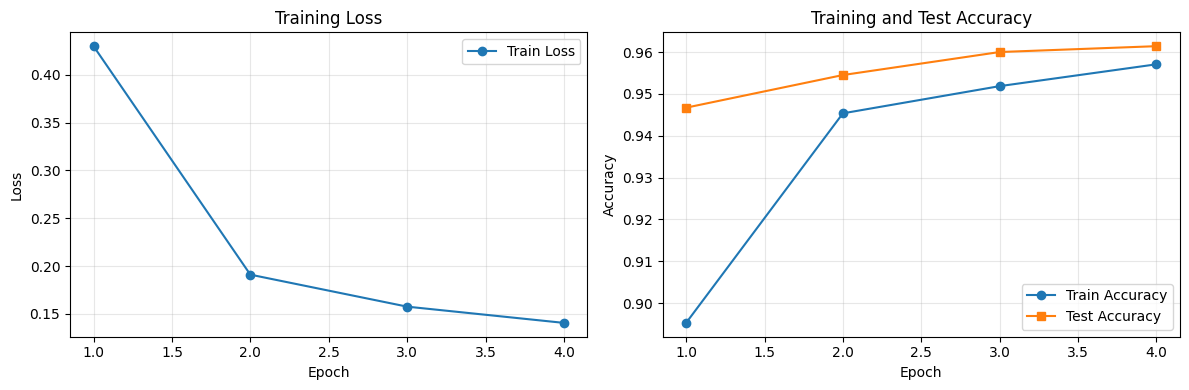


Final Results:
Train Accuracy: 0.9571
Test Accuracy:  0.9614


In [ ]:
# plotting training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# loss curve
axes[0].plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# accuracy curve
axes[1].plot(range(1, num_epochs+1), train_accs, marker='o', label='Train Accuracy')
axes[1].plot(range(1, num_epochs+1), test_accs, marker='s', label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Test Accuracy')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# printing final metrics
print(f"\nFinal Results:")
print(f"Train Accuracy: {train_accs[-1]:.4f}")
print(f"Test Accuracy:  {test_accs[-1]:.4f}")

## Training Performance

The DenseNet121 classifier was fine-tuned on the MNIST training set (60,000 images)
for 4 epochs using the Adam optimizer with learning rate 1e-3.
Only the final classifier head was trained, while the convolutional feature extractor remained frozen.

**Final performance**
- Train accuracy: **95.71%**
- Test accuracy: **96.14%**

### Analysis

The training curves show effective convergence with minimal overfitting.
The training loss decreases consistently from 0.43 to 0.14 over 4 epochs, while both train and test accuracy improve steadily.
The small gap between train accuracy (95.71%) and test accuracy (96.14%) indicates good generalization to unseen MNIST digits.
The fact that test accuracy slightly exceeds train accuracy in the final epoch suggests that the model has learned robust digit classification features that transfer well to the test distribution.

This accuracy on MNIST is high enough to consider the fine tuned model suitable for reliable XAI analysis in the subsequent sections.

## Selection of GOOD and BAD examples

To evaluate the XAI methods, two representative test samples are selected:

- a **GOOD** example: a correctly classified digit  
- a **BAD** example: a misclassified digit  

This way, the saliency maps explain both a correct decision and a concrete model error on the same MNIST classification task.

In [ ]:
# search the test set for one correct and one incorrect prediction
model.eval()
good_img = bad_img = None
good_label = good_pred = None
bad_label = bad_pred = None

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        _, preds = out.max(1)

        for img, true_y, pred_y in zip(x, y, preds.cpu()):
            if good_img is None and true_y.item() == pred_y.item():
                good_img = img.unsqueeze(0)
                good_label = true_y.item()
                good_pred  = pred_y.item()
            if bad_img is None and true_y.item() != pred_y.item():
                bad_img = img.unsqueeze(0)
                bad_label = true_y.item()
                bad_pred  = pred_y.item()
            if good_img is not None and bad_img is not None:
                break
        if good_img is not None and bad_img is not None:
            break

image_good = good_img
image_bad  = bad_img

print(f"GOOD: true label {good_label}, predicted {good_pred}")
print(f"BAD : true label {bad_label}, predicted {bad_pred}")

GOOD: true label 7, predicted 7
BAD : true label 9, predicted 7


## Visualization of saliency maps

The following grid shows two rows (GOOD and BAD) and four columns (Integrated Gradients, Occlusion, SHAP, Grad-CAM). Each attribution map is min–max normalized to [0, 1] so that the colorbars share the same scale, making visual comparison across methods and examples easier.

- **GOOD example**: digit "7" correctly classified as class 7  
- **BAD example**: digit "9" misclassified as class 7

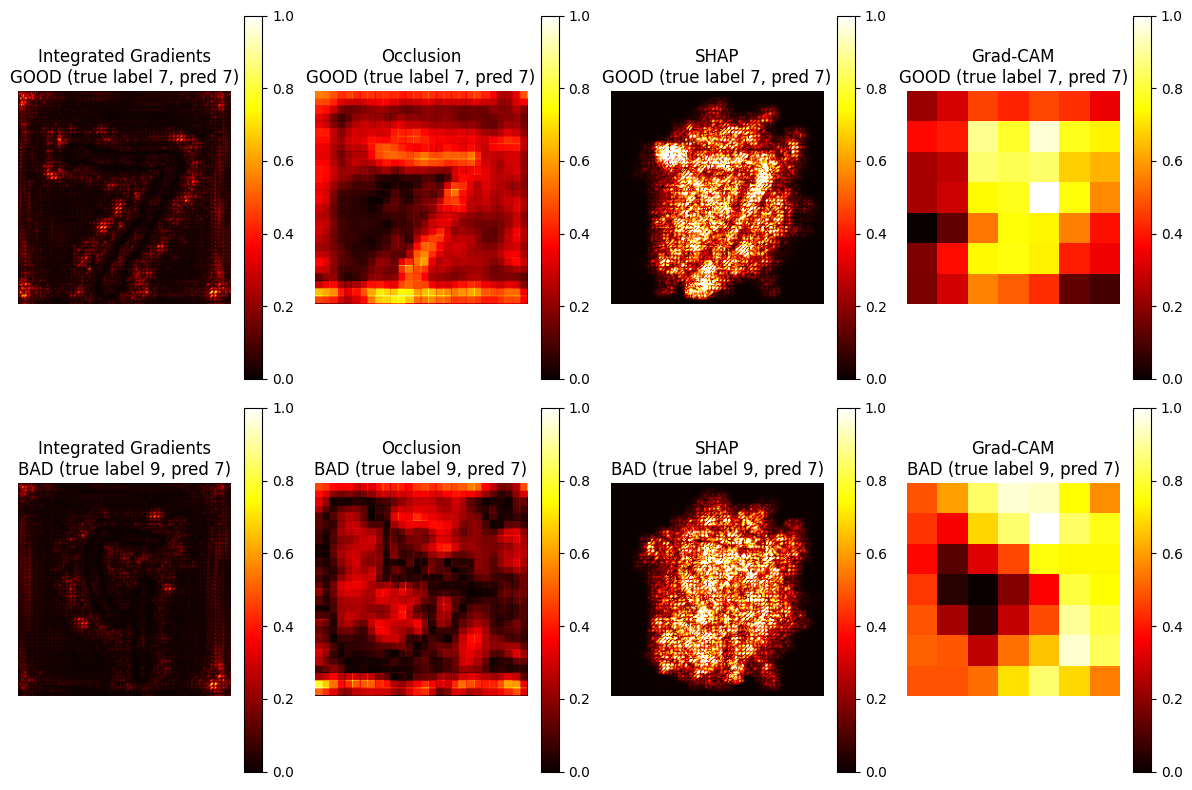

In [ ]:
# SHAP background (small batch of MNIST test images)
background_images, _ = get_samples(n=50) # !!! works with 3, test with 50 [ok]
background = background_images.to(device)

# GOOD attributions
ig_good   = compute_ig_attr(image_good, good_pred)
occ_good  = compute_occ_attr(image_good, good_pred)
shap_good = compute_shap_attr(image_good, background, good_pred)
gc_good    = compute_gradcam_attr(image_good, good_pred)

# BAD attributions
ig_bad   = compute_ig_attr(image_bad, bad_pred)
occ_bad  = compute_occ_attr(image_bad, bad_pred)
shap_bad = compute_shap_attr(image_bad, background, bad_pred)
gc_bad     = compute_gradcam_attr(image_bad, bad_pred)

# plotting the 2×4 matrix
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
titles = ["Integrated Gradients", "Occlusion", "SHAP", "Grad-CAM"]

# row 0: GOOD example
for j, (attr_map, title) in enumerate(zip([ig_good, occ_good, shap_good, gc_good], titles)):
    ax = axes[0, j]
    norm_map = minmax_normalize(attr_map)
    im = ax.imshow(norm_map, cmap="hot", vmin=0.0, vmax=1.0)
    ax.set_title(f"{title}\nGOOD (true label {good_label}, pred {good_pred})")
    ax.axis("off")
    fig.colorbar(im, ax=ax)

# row 1: BAD example
for j, (attr_map, title) in enumerate(zip([ig_bad, occ_bad, shap_bad, gc_bad], titles)):
    ax = axes[1, j]
    norm_map = minmax_normalize(attr_map)
    im = ax.imshow(norm_map, cmap="hot", vmin=0.0, vmax=1.0)
    ax.set_title(f"{title}\nBAD (true label {bad_label}, pred {bad_pred})")
    ax.axis("off")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Analysis of saliency maps

The visualization shows saliency maps for two MNIST test examples analyzed with four XAI methods:
**Integrated Gradients**, **Occlusion**, **SHAP**, and **Grad-CAM**.
The GOOD example is a digit "7" correctly classified as class 7, while the BAD example is a digit "9" misclassified as class 7.

### GOOD example (digit 7, correctly classified)

All four explanation methods focus on the main stroke of the digit, indicating that the fine tuned model relies on meaningful visual features for confident predictions.

**Integrated Gradients** produces a detailed, high-resolution attribution map that follows the contour of the digit precisely.
The brightest regions correspond to the diagonal stroke and horizontal bar characteristic of the digit "7", with fine grained variations highlighting specific edges and transitions.

**Occlusion** generates a smoother, more spatially aggregated map with broader activation regions.
The areas of high importance are concentrated around the central and upper portions of the digit, consistent with the perturbation based nature of this method, which evaluates the impact of masking entire regions rather than individual pixels.

**SHAP** highlights the digit shape with strong, concentrated responses forming a clear outline of the "7". The attribution is well localized and aligns closely with the visible strokes, showing that the model’s prediction is grounded in the correct visual structures.

**Grad-CAM** focuses on a coarse region covering the central part of the digit, due to the low spatial resolution of the last convolutional feature maps.
Despite its lower granularity, the hottest areas still overlap with the main diagonal stroke, confirming that the model activates strongly on the body of the "7".

### BAD example (digit 9, misclassified as 7)

For the misclassified example, all methods reveal more scattered and ambiguous attribution patterns, providing insight into why the model makes an error.

**Integrated Gradients** shows activations spread across multiple regions of the digit, including peripheral areas that do not correspond to the defining features of either a "7" or a "9".
This scattered pattern suggests that the model is responding to ambiguous or spurious features rather than the main digit structure.

**Occlusion** exhibits broader, less focused high importance regions with activation extending beyond the core digit strokes.
The map indicates that occluding various parts of the image has comparable impact on the prediction, consistent with lower model confidence and uncertain classification.

**SHAP** produces a more diffuse attribution map compared to the correct example, with relevant regions spread across a larger portion of the image.
While it still highlights parts of the digit, the explanation lacks the sharp localization seen in the correctly classified case, reflecting the model’s confusion between similar looking digits (9 vs 7).

**Grad-CAM** highlights a coarse region that only partially overlaps the loop of the "9" and extends into background areas.
This misaligned focus supports the interpretation that the model is not attending to the most discriminative parts of the digit when producing the incorrect class 7 prediction.

### Comparative analysis

The comparison between GOOD and BAD examples reveals key differences in how the fine tuned model processes correct versus incorrect predictions:

1. **Localization**: Correct predictions show concentrated, well-defined saliency maps aligned with digit strokes, while misclassifications exhibit scattered, diffuse patterns.
2. **Consistency across methods**: For the correctly classified digit, the XAI methods largely agree on the important regions. For the misclassification, there is less consensus, with each method highlighting somewhat different areas.
3. **Visual interpretability**: The GOOD example’s saliency maps are immediately interpretable and match human intuition about which pixels define a "7". The BAD example’s maps are harder to interpret, mirroring the model’s uncertainty.

These differences demonstrate how XAI methods can diagnose model errors and distinguish between confident, feature based predictions and uncertain classifications driven by ambiguous visual patterns.
This type of analysis is valuable for understanding model reliability and identifying cases where predictions may be untrustworthy despite seemingly reasonable output probabilities.

Note: the optional exercise of part 3 is **not implemented**.

---

## 📚 References & Resources

- [MNIST Dataset](https://www.geeksforgeeks.org/machine-learning/mnist-dataset/)

- [densenet121](https://docs.pytorch.org/vision/master/models/generated/torchvision.models.densenet121.html)

- [Integrated gradients for MNIST](https://docs.seldon.ai/alibi-explain/explanations/examples/integrated-gradients/integrated_gradients_mnist)

- [Model Understanding with Captum](https://docs.pytorch.org/tutorials/beginner/introyt/captumyt.html)

- [Let's understanding CNN model](https://www.kaggle.com/code/ohseokkim/let-s-understanding-cnn-model)

- [How to Use Captum for PyTorch Model Interpretability](https://eureka.patsnap.com/article/how-to-use-captum-for-pytorch-model-interpretability)

- [PyTorch Deep Explainer MNIST example](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html)

- [Model Interpretability using Captum](https://docs.pytorch.org/tutorials/recipes/recipes/Captum_Recipe.html)

- Various YouTube videos

- ChatGPT – used for improving documentation clarity and polishing markdown sections
